In [179]:
!pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org tensorflow tensorflow-addons matplotlib

ERROR: Could not find a version that satisfies the requirement tensorflow-addons (from versions: none)
ERROR: No matching distribution found for tensorflow-addons


In [ ]:
!pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org tensorflow-addons==0.20.0

---------------------------------------------------------------------------------------------

------------------------------------------------------  fin-----------------------------------

changer le code suivante pour repondre a cette logique :
je veut d'abord split la dataset wheat_leaf (D) en train (D_train) and test (D_test) and valid (D_valid) apres appliquer data augmentation avec ADASYN  sur la dataset D pour optenir D_augmented  apres fusioner D_augmented avec D_train pour avoir la dataset D_augmented_train apres appliquer MobileNetV2 sur D_augmented_train and D_valid apres tester avec D_test , sachant que la dataset D contient 3 classes (Healthy,  septoria, stripe_rust)

In [19]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


In [20]:
# -------------------------
# Part 1: CycleGAN Model Definition
# -------------------------
class CycleGAN(tf.keras.Model):
    def __init__(self, generator_g, generator_f, discriminator_x, discriminator_y, lambda_cycle=10):
        super(CycleGAN, self).__init__()
        self.generator_g = generator_g
        self.generator_f = generator_f
        self.discriminator_x = discriminator_x
        self.discriminator_y = discriminator_y
        self.lambda_cycle = lambda_cycle

    def compile(self, g_optimizer, f_optimizer, d_x_optimizer, d_y_optimizer, loss_fn):
        super(CycleGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.f_optimizer = f_optimizer
        self.d_x_optimizer = d_x_optimizer
        self.d_y_optimizer = d_y_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        real_x, real_y = data
        with tf.GradientTape(persistent=True) as tape:
            fake_y = self.generator_g(real_x, training=True)
            cycled_x = self.generator_f(fake_y, training=True)
            fake_x = self.generator_f(real_y, training=True)
            cycled_y = self.generator_g(fake_x, training=True)

            disc_real_x = self.discriminator_x(real_x, training=True)
            disc_fake_x = self.discriminator_x(fake_x, training=True)
            disc_real_y = self.discriminator_y(real_y, training=True)
            disc_fake_y = self.discriminator_y(fake_y, training=True)

            gen_g_loss = self.loss_fn(tf.ones_like(disc_fake_y), disc_fake_y)
            gen_f_loss = self.loss_fn(tf.ones_like(disc_fake_x), disc_fake_x)
            cycle_loss_x = tf.reduce_mean(tf.abs(real_x - cycled_x)) * self.lambda_cycle
            cycle_loss_y = tf.reduce_mean(tf.abs(real_y - cycled_y)) * self.lambda_cycle
            total_gen_g_loss = gen_g_loss + cycle_loss_x
            total_gen_f_loss = gen_f_loss + cycle_loss_y

            disc_x_loss = self.loss_fn(tf.ones_like(disc_real_x), disc_real_x) + \
                          self.loss_fn(tf.zeros_like(disc_fake_x), disc_fake_x)
            disc_y_loss = self.loss_fn(tf.ones_like(disc_real_y), disc_real_y) + \
                          self.loss_fn(tf.zeros_like(disc_fake_y), disc_fake_y)

        generator_g_gradients = tape.gradient(total_gen_g_loss, self.generator_g.trainable_variables)
        generator_f_gradients = tape.gradient(total_gen_f_loss, self.generator_f.trainable_variables)
        discriminator_x_gradients = tape.gradient(disc_x_loss, self.discriminator_x.trainable_variables)
        discriminator_y_gradients = tape.gradient(disc_y_loss, self.discriminator_y.trainable_variables)

        self.g_optimizer.apply_gradients(zip(generator_g_gradients, self.generator_g.trainable_variables))
        self.f_optimizer.apply_gradients(zip(generator_f_gradients, self.generator_f.trainable_variables))
        self.d_x_optimizer.apply_gradients(zip(discriminator_x_gradients, self.discriminator_x.trainable_variables))
        self.d_y_optimizer.apply_gradients(zip(discriminator_y_gradients, self.discriminator_y.trainable_variables))

        return {
            'gen_g_loss': total_gen_g_loss,
            'gen_f_loss': total_gen_f_loss,
            'disc_x_loss': disc_x_loss,
            'disc_y_loss': disc_y_loss
        }


In [21]:
def build_generator():
    model = tf.keras.Sequential([
        layers.Input(shape=(256, 256, 3)),
        layers.Conv2D(64, (7, 7), padding='same'),
        layers.ReLU(),
        layers.Conv2DTranspose(3, (7, 7), padding='same')
    ])
    return model

def build_discriminator():
    model = tf.keras.Sequential([
        layers.Input(shape=(256, 256, 3)),
        layers.Conv2D(64, (4, 4), strides=2, padding='same'),
        layers.LeakyReLU(),
        layers.Conv2D(1, (4, 4), padding='same')
    ])
    return model


In [22]:
# -------------------------
# Part 2: Dataset Loading and Augmentation
# -------------------------
def load_dataset(dataset_path, img_size=(256, 256)):
    images = []
    labels = []
    class_names = os.listdir(dataset_path)  # Automatically detect class folders
    class_labels = {name: idx for idx, name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(dataset_path, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            img = img / 255.0
            images.append(img)
            labels.append(class_labels[class_name])

    return np.array(images), np.array(labels), class_names


In [27]:
dataset_path = "./wheat_leaf"  # Replace with your dataset path
images, labels, class_names = load_dataset(dataset_path, img_size=(256, 256))

# Normalize images
images = images / 255.0  # Normalization


In [28]:
# Train CycleGAN
generator_g = build_generator()
generator_f = build_generator()
discriminator_x = build_discriminator()
discriminator_y = build_discriminator()

cyclegan = CycleGAN(generator_g, generator_f, discriminator_x, discriminator_y)
cyclegan.compile(
    g_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    f_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    d_x_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    d_y_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)


In [29]:
# (-------------------------
# Part 3: Data Splitting
# -------------------------
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    augmented_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
valid_generator = train_datagen.flow_from_directory(
    augmented_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    augmented_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 327 images belonging to 3 classes.
Found 80 images belonging to 3 classes.
Found 407 images belonging to 3 classes.


In [30]:
# Generate augmented images
augmented_path = './wheat_leaf_augmented'
os.makedirs(augmented_path, exist_ok=True)

for class_name in class_names:
    class_dir = os.path.join(augmented_path, class_name)
    os.makedirs(class_dir, exist_ok=True)

    for img, label in zip(images, labels):
        if label == class_names.index(class_name):  # Augment images per class
            img = np.expand_dims(img, axis=0)  # Add batch dimension
            augmented_img = generator_g.predict(img)[0]
            augmented_img = (augmented_img * 255).astype(np.uint8)  # Scale back to [0, 255]
            img_name = f"augmented_{len(os.listdir(class_dir))}.jpg"
            cv2.imwrite(os.path.join(class_dir, img_name), augmented_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [31]:
from tensorflow.keras.applications import MobileNetV2
# -------------------------
# Part 4: Train MobileNetV2 Classifier
# -------------------------
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


In [32]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(len(class_names), activation='softmax')
])


In [33]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [34]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=30
)


D:\anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.4821 - loss: 1.0248 - val_accuracy: 0.5500 - val_loss: 0.9166
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 696ms/step - accuracy: 0.7845 - loss: 0.6281 - val_accuracy: 0.6625 - val_loss: 0.7564
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 620ms/step - accuracy: 0.8338 - loss: 0.5068 - val_accuracy: 0.6875 - val_loss: 0.6947
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 741ms/step - accuracy: 0.8401 - loss: 0.3845 - val_accuracy: 0.7250 - val_loss: 0.6816
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 674ms/step - accuracy: 0.9108 - loss: 0.3253 - val_accuracy: 0.7500 - val_loss: 0.6336
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 623ms/step - accuracy: 0.9057 - loss: 0.2791 - val_accuracy: 0.7375 - val_loss: 0.6516
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 639ms/step - accuracy: 0.9445 - loss: 0.2460 - val_accuracy: 0.7625 - val_loss: 0.5945
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 602ms/step - accuracy: 0.9583 - loss: 0.2089 - val_accuracy: 0.73

In [35]:
# -------------------------
# Part 5: Evaluate and Confusion Matrix
# -------------------------
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 615ms/step - accuracy: 0.9404 - loss: 0.2133
Test Loss: 0.17277760803699493
Test Accuracy: 0.9508599638938904


In [36]:

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes



13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step 


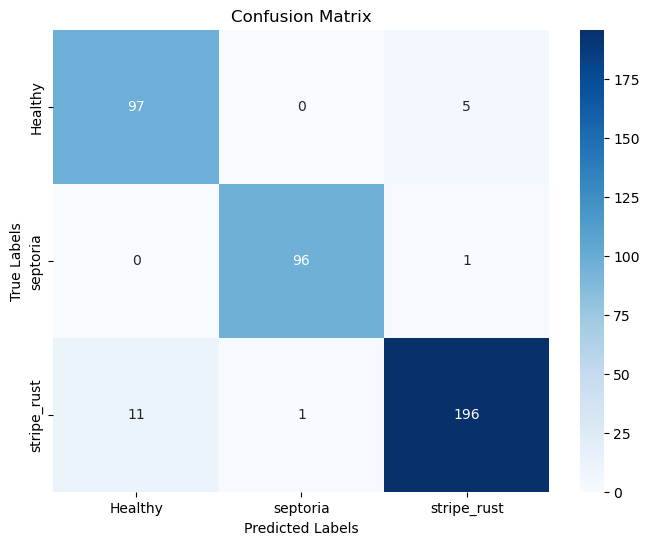


Classification Report:

              precision    recall  f1-score   support

     Healthy       0.90      0.95      0.92       102
    septoria       0.99      0.99      0.99        97
 stripe_rust       0.97      0.94      0.96       208

    accuracy                           0.96       407
   macro avg       0.95      0.96      0.96       407
weighted avg       0.96      0.96      0.96       407



In [107]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_names))


In [109]:
import cv2
import numpy as np

# Function to predict the label of a single image
def predict_image(model, image_path, class_labels):
    """
    Predicts the label for a given image using the trained model.

    Args:
        model: Trained Keras model (already loaded in memory).
        image_path: Path to the test image.
        class_labels: List of class labels in the same order as the model output.

    Returns:
        The predicted label for the image.
    """
    # Load and preprocess the image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at path: {image_path}")
    image = cv2.resize(image, (224, 224))  # Resize to match model's input shape
    image = image / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Predict the class
    prediction = model.predict(image)
    predicted_class_index = np.argmax(prediction, axis=1)[0]

    # Map the predicted index to the corresponding label
    predicted_label = class_labels[predicted_class_index]
    return predicted_label

# Example usage
if __name__ == "__main__":
    # Assuming `model` is already loaded and trained
    # Define the class labels (ensure they match the order used during training)
    class_labels = ["Healthy", "septoria", "stripe_rust"]  # Replace with your actual class names

    # Test with a specific image
    test_image_path = "test.jpg"  # Replace with the path to your test image
    try:
        predicted_label = predict_image(model, test_image_path, class_labels)
        print(f"The predicted label for the test image is: {predicted_label}")
    except Exception as e:
        print(f"Error: {e}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
The predicted label for the test image is: septoria


-------------------------------------- Final version-----------------------------------------------

In [37]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns



In [38]:
# -------------------------
# Part 1: Load and Split Dataset
# -------------------------
def load_dataset(dataset_path, img_size=(256, 256)):
    images = []
    labels = []
    class_names = os.listdir(dataset_path)
    class_labels = {name: idx for idx, name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(dataset_path, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            img = img / 255.0
            images.append(img)
            labels.append(class_labels[class_name])

    return np.array(images), np.array(labels), class_names



In [39]:
dataset_path = "./wheat_leaf"
images, labels, class_names = load_dataset(dataset_path)



In [40]:
# Split dataset into train, test, and valid
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, stratify=labels, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)



In [41]:
# -------------------------
# Part 2: Data Augmentation with CycleGAN
# -------------------------
def build_generator():
    model = tf.keras.Sequential([
        layers.Input(shape=(256, 256, 3)),
        layers.Conv2D(64, (7, 7), padding='same'),
        layers.ReLU(),
        layers.Conv2DTranspose(3, (7, 7), padding='same')
    ])
    return model


In [42]:
generator_g = build_generator()

# Generate augmented dataset
D_augmented = []
for img in X_train:
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    augmented_img = generator_g.predict(img)[0]
    augmented_img = np.clip(augmented_img, 0, 1)  # Ensure values are in range [0, 1]
    D_augmented.append(augmented_img)

D_augmented = np.array(D_augmented)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [43]:
# Combine D_train with D_augmented
D_augmented_train = np.concatenate((X_train, D_augmented), axis=0)
y_augmented_train = np.concatenate((y_train, y_train), axis=0)



______________________________________________ MobileNetV2____________________________________________

In [44]:
# -------------------------
# Part 3: Train MobileNetV2 Classifier
# -------------------------
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [45]:
# Resize images for MobileNetV2
def resize_images(images, target_size=(224, 224)):
    resized = [cv2.resize(img, target_size) for img in images]
    return np.array(resized)

D_augmented_train_resized = resize_images(D_augmented_train)
X_valid_resized = resize_images(X_valid)



In [46]:
history = model.fit(
    D_augmented_train_resized, y_augmented_train,
    validation_data=(X_valid_resized, y_valid),
    epochs=30,
    batch_size=32
)

Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 989ms/step - accuracy: 0.4417 - loss: 1.1537 - val_accuracy: 0.7213 - val_loss: 0.6937
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 552ms/step - accuracy: 0.7476 - loss: 0.6073 - val_accuracy: 0.7705 - val_loss: 0.5156
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 546ms/step - accuracy: 0.7877 - loss: 0.4638 - val_accuracy: 0.8525 - val_loss: 0.4339
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 578ms/step - accuracy: 0.8805 - loss: 0.3653 - val_accuracy: 0.8361 - val_loss: 0.4007
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 561ms/step - accuracy: 0.9069 - loss: 0.3058 - val_accuracy: 0.8361 - val_loss: 0.3636
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 591ms/step - accuracy: 0.8950 - loss: 0.2995 - val_accuracy: 0.8197 - val_loss: 0.3490
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 705ms/step - accuracy: 0.9254 - loss: 0.2564 - val_accuracy: 0.8525 - val_loss: 0.3407
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 705ms/step - accuracy: 0.9346 - loss: 0.2106 - val_accu

In [47]:
# -------------------------
# Part 4: Evaluate on Test Set
# -------------------------
X_test_resized = resize_images(X_test)

test_loss, test_accuracy = model.evaluate(X_test_resized, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")



2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 613ms/step - accuracy: 0.8831 - loss: 0.2159
Test Loss: 0.19868625700473785
Test Accuracy: 0.8870967626571655


In [48]:
y_pred = model.predict(X_test_resized)
y_pred_classes = np.argmax(y_pred, axis=1)



2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step


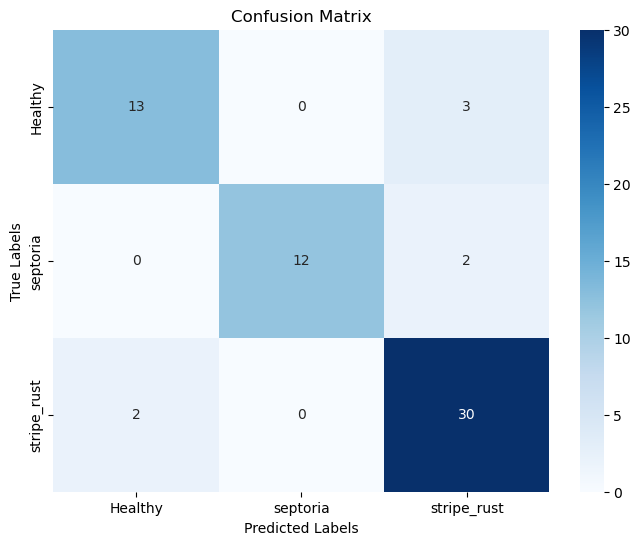


Classification Report:

              precision    recall  f1-score   support

     Healthy       0.87      0.81      0.84        16
    septoria       1.00      0.86      0.92        14
 stripe_rust       0.86      0.94      0.90        32

    accuracy                           0.89        62
   macro avg       0.91      0.87      0.89        62
weighted avg       0.89      0.89      0.89        62



In [49]:
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_classes, target_names=class_names))


______________________________________________________ DenseNet121 ________________________________________

In [50]:
from tensorflow.keras.applications import DenseNet121
# -------------------------
# Part 3: Train MobileNetV2 Classifier
# -------------------------
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [51]:
# Resize images for MobileNetV2
def resize_images(images, target_size=(224, 224)):
    resized = [cv2.resize(img, target_size) for img in images]
    return np.array(resized)

D_augmented_train_resized = resize_images(D_augmented_train)
X_valid_resized = resize_images(X_valid)



In [52]:
history = model.fit(
    D_augmented_train_resized, y_augmented_train,
    validation_data=(X_valid_resized, y_valid),
    epochs=30,
    batch_size=32
)

Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 175s 5s/step - accuracy: 0.3790 - loss: 1.1896 - val_accuracy: 0.6230 - val_loss: 0.9215
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.6679 - loss: 0.7961 - val_accuracy: 0.7049 - val_loss: 0.7167
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.7231 - loss: 0.6721 - val_accuracy: 0.7541 - val_loss: 0.6109
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.7981 - loss: 0.5535 - val_accuracy: 0.7705 - val_loss: 0.5407
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.7699 - loss: 0.5492 - val_accuracy: 0.7869 - val_loss: 0.4851
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.8353 - loss: 0.4624 - val_accuracy: 0.8033 - val_loss: 0.4611
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.8733 - loss: 0.4017 - val_accuracy: 0.8197 - val_loss: 0.4270
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.8590 - loss: 0.4091 - val_accuracy: 0.8033 - val_loss

In [53]:
# -------------------------
# Part 4: Evaluate on Test Set
# -------------------------
X_test_resized = resize_images(X_test)

test_loss, test_accuracy = model.evaluate(X_test_resized, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")



2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8511 - loss: 0.2930
Test Loss: 0.28266260027885437
Test Accuracy: 0.8548387289047241


In [54]:
y_pred = model.predict(X_test_resized)
y_pred_classes = np.argmax(y_pred, axis=1)


1/2 ━━━━━━━━━━━━━━━━━━━━ 25s 26s/stepWARNING:tensorflow:5 out of the last 288 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000029BAEEE72E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 46s 21s/step


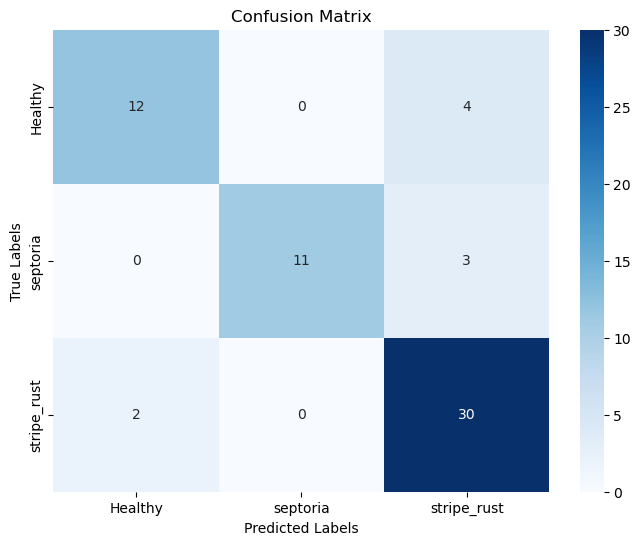


Classification Report:

              precision    recall  f1-score   support

     Healthy       0.86      0.75      0.80        16
    septoria       1.00      0.79      0.88        14
 stripe_rust       0.81      0.94      0.87        32

    accuracy                           0.85        62
   macro avg       0.89      0.82      0.85        62
weighted avg       0.87      0.85      0.85        62



In [55]:
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_classes, target_names=class_names))


________________________________________________ DenseNet169 ______________________________________________________

In [56]:
from tensorflow.keras.applications import DenseNet169
# -------------------------
# Part 3: Train MobileNetV2 Classifier
# -------------------------
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [57]:
# Resize images for MobileNetV2
def resize_images(images, target_size=(224, 224)):
    resized = [cv2.resize(img, target_size) for img in images]
    return np.array(resized)

D_augmented_train_resized = resize_images(D_augmented_train)
X_valid_resized = resize_images(X_valid)



In [58]:
history = model.fit(
    D_augmented_train_resized, y_augmented_train,
    validation_data=(X_valid_resized, y_valid),
    epochs=30,
    batch_size=32
)

Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 232s 6s/step - accuracy: 0.4595 - loss: 1.1167 - val_accuracy: 0.6393 - val_loss: 0.8034
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 67s 4s/step - accuracy: 0.7032 - loss: 0.7088 - val_accuracy: 0.7541 - val_loss: 0.5814
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.8047 - loss: 0.5314 - val_accuracy: 0.8033 - val_loss: 0.4819
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 65s 4s/step - accuracy: 0.8591 - loss: 0.4316 - val_accuracy: 0.8525 - val_loss: 0.4330
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 63s 4s/step - accuracy: 0.8740 - loss: 0.3938 - val_accuracy: 0.8852 - val_loss: 0.3878
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 65s 4s/step - accuracy: 0.8819 - loss: 0.3644 - val_accuracy: 0.8689 - val_loss: 0.3737
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 63s 4s/step - accuracy: 0.9113 - loss: 0.3240 - val_accuracy: 0.8689 - val_loss: 0.3730
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.9101 - loss: 0.2824 - val_accuracy: 0.8525 - val_loss

In [59]:
# -------------------------
# Part 4: Evaluate on Test Set
# -------------------------
X_test_resized = resize_images(X_test)

test_loss, test_accuracy = model.evaluate(X_test_resized, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")



2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.9039 - loss: 0.2419
Test Loss: 0.2659814655780792
Test Accuracy: 0.8870967626571655


In [60]:
y_pred = model.predict(X_test_resized)
y_pred_classes = np.argmax(y_pred, axis=1)


2/2 ━━━━━━━━━━━━━━━━━━━━ 38s 17s/step


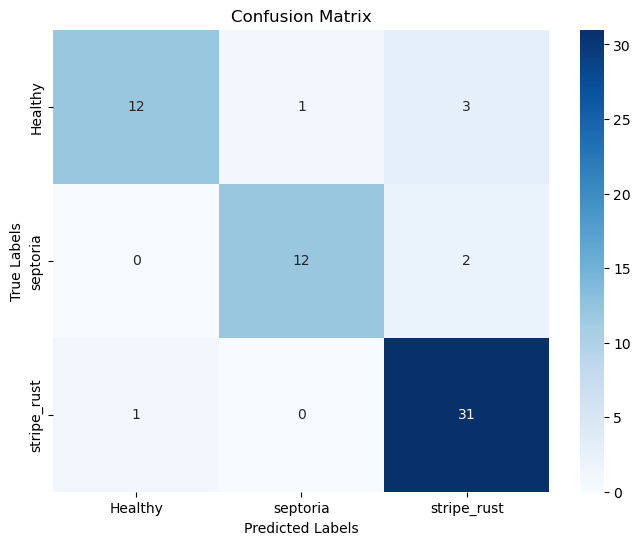


Classification Report:

              precision    recall  f1-score   support

     Healthy       0.92      0.75      0.83        16
    septoria       0.92      0.86      0.89        14
 stripe_rust       0.86      0.97      0.91        32

    accuracy                           0.89        62
   macro avg       0.90      0.86      0.88        62
weighted avg       0.89      0.89      0.88        62



In [61]:
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_classes, target_names=class_names))
